In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
gE = 1/5
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}

# use pyross stochastic to generate traj and save 

sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data=sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEIR_sto_traj.npy', data_array)

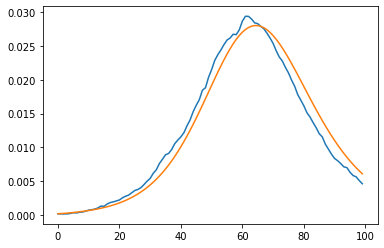

In [4]:
# load the data and rescale to intensive variables 
x = np.load('SEIR_sto_traj.npy').astype('float')
x = x/N
steps = 101


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SEIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x0, Tf, Nf, det_model, contactMatrix)
full_cov = full_cov.todense()
plt.plot(x[1:,3*M])
plt.plot(xm[:,3*M])
plt.show()

In [5]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

977.0393732265347
1.3134140968322754


In [6]:
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm, can use as a lower bound for parameters 

alpha_g = 0.2
alpha_bounds = (0.1, 0.5) # large uncertainty on the fraction of asymptomatic people 
# the upper bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1) # large uncertainty on beta (e.g. during a lockdown, beta can be very low)

gIa_g = 0.2
gIa_bounds = (eps, 0.5) # large uncertainty on how quickly asymptomatic people recover 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) # tight bounds on gIs (can come from clinical data)

gE_g = 0.22
gE_bounds = (0.15, 0.25) # tight bounds on the exit rate from the exposed class 

fsa_g = 0.8 # assume we know this precisely 


# guesses for the unknown initial conditions 
E0_g = (E0+5)/N 
bounds_for_E = [(0.1/N, 100/N)]*M #large uncertainty 
Ia0_g = (Ia0+5)/N
bounds_for_Ia = [(0.1/N, 100/N)]*M #large uncertainty 
S0_g = (S0-10)/N
bounds_for_S = [(fi[i]-200/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# as a result of the van kampen system size expansion, Is0 does not have to be the same as the true value 
Is0_g = Is0/N 
bounds_for_Is = [(5/N, 14/N)]*M 

# optimisation parameters 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                    *bounds_for_S, *bounds_for_Is, *bounds_for_Ia, *bounds_for_Is])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, *S0_g, *E0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=4, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.16683449 0.04681731 0.29949652 0.14002517 0.19678415]
parameters: [0.16231941 0.04268032 0.31321804 0.141179   0.19377943]
parameters: [0.15397435 0.03457302 0.33865992 0.14443847 0.18829336]
parameters: [0.15106571 0.03140802 0.34756924 0.14591194 0.18651034]
parameters: [0.14915905 0.02919555 0.35348084 0.14698939 0.18538056]
parameters: [0.14766544 0.02735647 0.35813514 0.14791296 0.18450969]
parameters: [0.14672208 0.02609519 0.36112362 0.14857829 0.18396514]
parameters: [0.14601248 0.02501363 0.36342954 0.14917262 0.18356868]
parameters: [0.14555241 0.02419025 0.36497533 0.1496463  0.18331746]
parameters: [0.14546635 0.02389583 0.365326   0.14983318 0.18327397]
parameters: [0.14554379 0.02382561 0.36515927 0.14990202 0.1833199 ]
basinhopping step 0: f 983.633
parameters: [1.0e-01 1.0e-01 1.0e-04 1.3e-01 1.5e-01]
parameters: [0.1        0.03281692 0.12575894 0.13       0.15      ]
parameters: [0.1        0.01480343 0.15989769 0.13204471 0.15      ]
parameters: [0.1  

In [7]:
# save the parameters 
np.save('SEIR_param.npy', params)

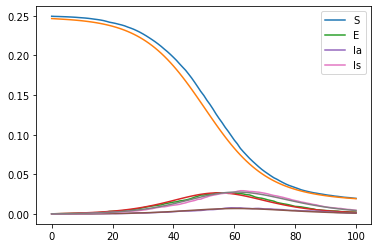

In [16]:
params = np.load('SEIR_param.npy')
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3], 'gE':params[4], 'fsa':0.8}
estimator.set_params(parameters)
x0 = params[5:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Ia')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Is')
plt.plot(x_det[:, 3*M])
plt.legend()
plt.show()

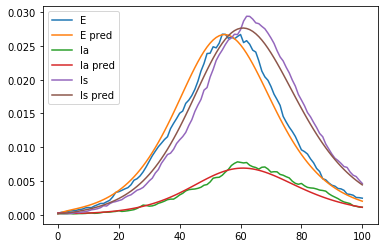

In [18]:
# now only plot E, Ia, Is 
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M], label='E pred')
plt.plot(x[:,2*M], label='Ia')
plt.plot(x_det[:, 2*M], label='Ia pred')
plt.plot(x[:,3*M], label='Is')
plt.plot(x_det[:, 3*M], label='Is pred')
plt.legend()
plt.show()

In [11]:
# the hessian for the parameters (5 x 5 in this case)
hess = estimator.hessian_latent_params(params, obs[1:], fltr, Tf, Nf, contactMatrix)
print(hess)

[[ 2.63156711e+04 -5.24743975e+05  3.86139296e+03  1.68519591e+05
  -4.60122285e+03]
 [-5.24743975e+05  3.86695497e+07 -2.83318795e+05 -3.56799938e+06
   1.24903724e+06]
 [ 3.86139296e+03 -2.83318795e+05  2.30351516e+03  2.56809740e+04
  -7.08653378e+03]
 [ 1.68519591e+05 -3.56799938e+06  2.56809740e+04  1.09034698e+06
  -3.50691180e+04]
 [-4.60122285e+03  1.24903724e+06 -7.08653378e+03 -3.50691180e+04
   3.90797300e+04]]
